In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import random
import gc
from time import time
random.seed(11)
%matplotlib inline
sns.set()

# Introduction

This project is drawn from a Kaggle competition (ends Aug 29. 2018) to predict loan outcomes.  Here's the official description:

*Many people struggle to get loans due to insufficient or non-existent credit histories. And, unfortunately, this population is often taken advantage of by untrustworthy lenders.*

*Home Credit strives to broaden financial inclusion for the unbanked population by providing a positive and safe borrowing experience. In order to make sure this underserved population has a positive loan experience, Home Credit makes use of a variety of alternative data--including telco and transactional information--to predict their clients' repayment abilities.*

*While Home Credit is currently using various statistical and machine learning methods to make these predictions, they're challenging Kagglers to help them unlock the full potential of their data. Doing so will ensure that clients capable of repayment are not rejected and that loans are given with a principal, maturity, and repayment calendar that will empower their clients to be successful.*

The dataset consists of seven tables: one main table with essential data for every loan example, and six subsidiary tables (e.g., previous application data) which may or may not have entries for any given loan listed in the main table.  The evaluation criterion is the area under the model's ROC curve.

### Challenges
The most obviously formidable challenge in this competition is the dataset, which is medium quantity, mixed type, high opacity, and high sparsity.  Here's what I mean and why these are challenges:
- <b>Medium quantity:</b> at 300K examples and 122 features in the main table alone, the dataset is large enough to impose some computational limits (or at least inconveniences) on our models and processes
- <b>Mixed type:</b> the features are a mix of quantitative, multi-categorical, and binary-categorical.  As most models can only handle quantitative or binary features, we face the choice of dropping features or ballooning dimensionality with dummy columns.
- <b>High opacity:</b> the nature of the data is poorly explained (column descriptions, where extant, are single-clause and non-American English), and we have no information about how it was collected.  This makes cleaning highly problematic.
- <b>High sparsity:</b> the subsidiary tables have entries for some example loans and not for others; and even the primary table with all our example loans is strewn with nulls and zeroes.

In particular, the combination of high opacity and high sparsity means that there will be a lot of guesswork involved in handling our null values.

The predictive modeling will also pose some challenges, but those challenges will be more typical and less specifically anticipable from just the data and the task.

### My approach
I'm going to begin by cleaning up the main table to produce a workable dataset.  I'll then run an array of basic models on this dataset to generate accuracy benchmarks and decide which model or models should be our main choice to optimize later.  Given the challenges described above, the best out-of-box models will probably be the newer gradient boosting models which are highly optimized and well-equipped to handle categorical variables (XGBoost, LightGBM, CatBoost).

Once we've established our best model type(s), we'll move on to feature engineering.  This will include various approaches to engineering combined features, imputing missing values, incorporating the ancillary tables, and feature reduction.  For each version of our our dataset, we'll run our working model and check the results against our benchmark to see how much the changes helped or harmed our accuracy.  Using this method, we'll create an optimal version of our dataset for our model to work on.

Finally, having engineered the best set of features we can, we'll run a hyperparameter sweep on our chosen model or models to achieve our highest possible accuracy score.  The pipeline of data transforms, feature engineering, and optimally-tuned model will constitute our complete predictive model.

# Load and clean

In [142]:
raw_apps_df = pd.read_csv("application_train.csv")
raw_apps_df.columns = [str.lower(column) for column in raw_apps_df.columns]

First we'll handle a few type fixes that we'll want done even for our raw dataset:

In [143]:
# convert Y/N to True/False booleans:
raw_apps_df['flag_own_car'] = raw_apps_df.flag_own_car=='Y'
raw_apps_df['flag_own_realty'] = raw_apps_df.flag_own_realty=='Y'
# convert gender M/F flag to boolean:
raw_apps_df['gender_female'] = raw_apps_df['code_gender']=='F'
raw_apps_df.drop('code_gender', axis=1, inplace=True)
# convert mistyped float/str column:
raw_apps_df['ext_source_1'] = raw_apps_df.ext_source_1.astype(float)

In [144]:
print(raw_apps_df.shape)
raw_apps_df.head()

(307511, 122)


,sk_id_curr,target,name_contract_type,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,...,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year,gender_female
0,100002,1,Cash loans,False,True,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
1,100003,0,Cash loans,False,False,0,270000.0,1293502.5,35698.5,1129500.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,100004,0,Revolving loans,True,True,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
3,100006,0,Cash loans,False,True,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
4,100007,0,Cash loans,False,True,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False


# Preparing the data: manual null elimination and feature combination

We're going to try several types of data preparation for our models.  For our initial examination and model testing, we'll want a manageably-sized and null-less dataset.  Later, when we use some feature reduction algorithms that can handle nulls directly, we'll want a version with the most basic cleaning and consolidation performed, but with most of the nulls left intact.

Here we'll begin with the basic cleaning and consolidation to produce a minimally prepped version of the dataset: *apps_df*.  We'll then create another version that's further consolidated and has all the nulls filled: *apps_small_df*.  We'll use the latter table for our data exploration and initial model testing.

#### A note on the housing columns: 
The columns describing client housing are numerous (46) and strewn with nulls.  They are all normalized to a 0-to-1 range, with numbers closer to zero representing lower quality or less expensive housing (e.g., small number of rooms, entrances, square feet).

Since many of the nulls represent legitimate zeros (has no basement square footage, or no non-living-rooms, or no home at all), most of the nulls probably represent zeros.  The only clear exception is years_build_medi, which represents the age of the building.  Since zero represents a new building, we can fill nulls with a 0.5 for average age.  

We can then combine all housing columns (other than housing age, where 0 is higher quality) into one column that represents the accumulated quality and expensiveness of the housing.  This combination will lose some data, but it's pretty arcane stuff that's unlikely to be individually significant, and cutting it will provide a drastic and extremely helpful reduction in dimensionality.

In [166]:
apps_df = raw_apps_df.copy()

In [167]:
# we're going to rename housing age and move it to the end so that it's kept separate from our housing quality score
apps_df['housing_age'] = apps_df.years_build_medi
apps_df.drop('years_build_medi', axis=1, inplace=True)

# the nulls for who was with the person when they applied should be 'Unaccompanied'
apps_df['name_type_suite'].fillna(value='Unaccompanied', inplace=True)

# almost all of the credit bureau call and social circle values are zero (median=0), 
# so we'll just manually impute zeroes for those:
for colname in ['amt_req_credit_bureau_hour', 
                'amt_req_credit_bureau_day',
                'amt_req_credit_bureau_week', 
                'amt_req_credit_bureau_mon', 
                'amt_req_credit_bureau_qrt', 
                'amt_req_credit_bureau_year',
                'obs_30_cnt_social_circle',
                'def_30_cnt_social_circle',
                'obs_60_cnt_social_circle',
                'def_60_cnt_social_circle']:
    apps_df[colname].fillna(value=0, inplace=True)

housing_cols = apps_df.columns[43:84]
housing_categoricals = ['fondkapremont_mode', 'housetype_mode', 'wallsmaterial_mode', 'emergencystate_mode']
apps_df['housing_null_count'] = apps_df[housing_cols].isnull().sum(axis=1)
apps_df['other_null_count'] = apps_df.isnull().sum(axis=1)
apps_df['housing_quality'] = apps_df[housing_cols].sum(axis=1) + apps_df['totalarea_mode']
# NOTE: the above sum function effectively imputes 0s for nulls, which is okay 
# since no basement area generally means no basement
apps_df.drop(housing_cols, axis=1, inplace=True)
apps_df.drop('totalarea_mode', axis=1, inplace=True)

That's all the cleaning and consolidation we need for our full dataset.  

Now let's create the smaller null-less dataset for initial exploration and testing:

In [168]:
apps_small_df = apps_df.copy()
apps_small_df.housing_age.fillna(0.5, inplace=True)

# we'll group all void occupation types into 'Other/unemployed' since it's not clear whether
# the existing category 'Laborer' means 'Other'
apps_small_df['occupation_type'].fillna(value='Unemployed/other', inplace=True)

# for vehicle age, we'll say that having no car is like having a really old car
apps_small_df['own_car_age'].fillna(value=75, inplace=True)

apps_small_df[housing_categoricals] = apps_small_df[housing_categoricals].fillna(value='Unknown')

# and for the external data sources we'll just impute the median of 0.5
for colname in ['ext_source_1', 'ext_source_2', 'ext_source_3']:
    apps_small_df[colname].fillna(value=0.5, inplace=True)
    
# there are just 278 amt_goods_price nulls; we'll impute the median
apps_small_df['own_car_age'].fillna(value=450000, inplace=True)    

# and we'll drop the 15 other scattered nulls in the dataset
apps_small_df.dropna(inplace=True)

# Only three of the 20 document-submitted-flag columns have more than 10% submission rates.  The rest are very low, 
# with mostly only a few submissions out of 700K applicants.  We'll combine these.
docs_to_sum = [col for col in apps_small_df.columns[52:72] 
               if col not in ['flag_document_3', 'flag_document_6', 'flag_document_8']]
apps_small_df['other_docs_submitted'] = apps_small_df[docs_to_sum].sum(axis=1)
apps_small_df.drop(docs_to_sum, axis=1, inplace=True)

# some more column consolidation:
req_cols = ['amt_req_credit_bureau_hour', 
            'amt_req_credit_bureau_day',
            'amt_req_credit_bureau_week', 
            'amt_req_credit_bureau_mon', 
            'amt_req_credit_bureau_qrt', 
            'amt_req_credit_bureau_year']
apps_small_df['amt_req'] = apps_small_df[req_cols].sum(axis=1)
apps_small_df.drop(req_cols, axis=1, inplace=True)

soc_cols = ['obs_30_cnt_social_circle',
            'def_30_cnt_social_circle',
            'obs_60_cnt_social_circle',
            'def_60_cnt_social_circle']
apps_small_df['soc_cols'] = apps_small_df[soc_cols].sum(axis=1)
apps_small_df.drop(soc_cols, axis=1, inplace=True)

In [169]:
print("Small dataset feature count: ", apps_small_df.shape[1])
print("Large dataset feature count: ", apps_df.shape[1])

Small dataset feature count:  59
Large dataset feature count:  83


# Examining the data

### Outcome distribution

First, let's take a look at our target variable distribution.

In [185]:
apps_df.target.value_counts()

0    282416
1     24804
Name: target, dtype: int64

This is definitely an imbalanced dataset (8% positives), but it's not terribly skewed.  Since it's most important not to give loans that will default, we want to place some priority on catching all defaults, which means eliminating false negatives.  Given this priority, F1-score makes sense as a measure that emphasizes positives identification (it doesn't incorporate true negatives in its formula).

### Core features distribution

Let's take a look at the distributions of income levels, loan amounts, and loan annuities:

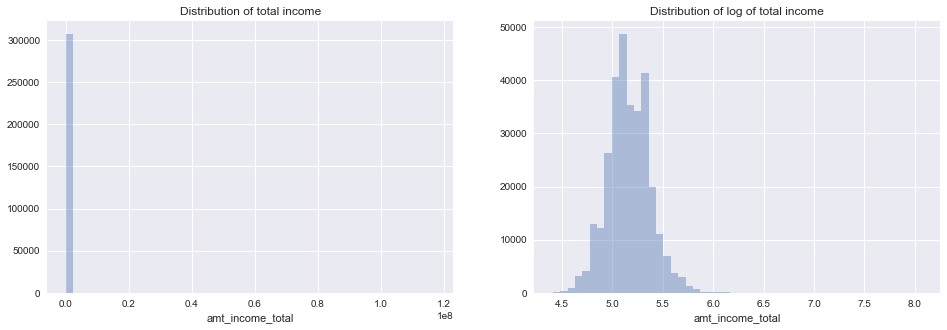

In [518]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_income_total, kde=False)
plt.title("Distribution of total income")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_income_total), kde=False)
plt.title("Distribution of log of total income")
plt.show()

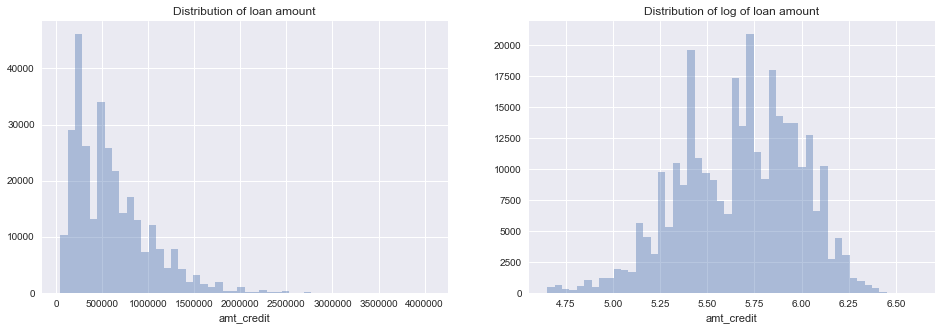

In [519]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_credit, kde=False)
plt.title("Distribution of loan amount")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_credit), kde=False)
plt.title("Distribution of log of loan amount")
plt.show()

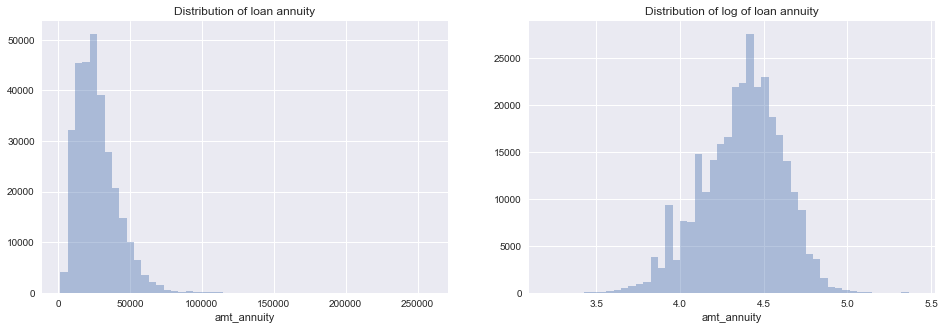

In [520]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(apps_df.amt_annuity, kde=False)
plt.title("Distribution of loan annuity")
plt.subplot(1,2,2)
sns.distplot(np.log10(apps_df.amt_annuity), kde=False)
plt.title("Distribution of log of loan annuity")
plt.show()

For all three of these statistics, a log transform is required to achieve a normal distribution.  Since many models assume normality (or at least work better with normally distributed features), we probably want to apply the log transform to the features in our dataset.  First, though, let's take a look at their scatterplot:

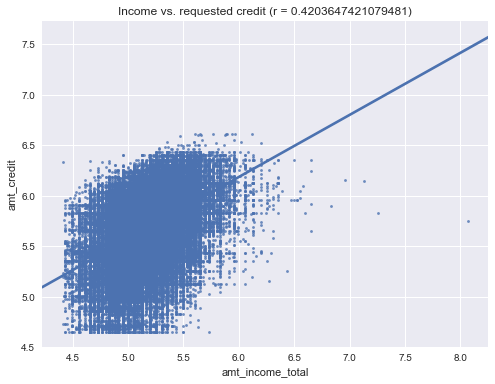

In [425]:
from scipy.stats import pearsonr
plt.figure(figsize=(8,6))
x = np.log10(apps_df.amt_income_total)
y = np.log10(apps_df.amt_credit)
sns.regplot(x,y, scatter_kws={'s':8})
pcc = pearsonr(x,y)[0]
plt.title("Income vs. requested credit (r = {})".format(pcc))
plt.show()

This tells us several things.  First, amount of income and amount of loan are strongly correlated (no surprise therE).  Second, there are a couple large outliers in our dataset where the income amount is over 10 million.  These might be worth eliminating, given that they're likely to be throw off our broader patterns.

Third, we can see that our minima display pretty hard cutoffs.  The smallest loans requested are 45,000 (units unknown); given that there are 230 loan requests of this amount and none of 50,000, it probably represents a minumum amount policy.  The smallest income reported is 25,650 (units unspecified); the income amounts display a more gradual decay toward the minum, however.

Given what we've learned, let's drop our three largest outliers and replace amt_credit and amt_income_total with logs of their values.

In [230]:
apps_df = apps_df[apps_df.amt_income_total < 1e7]
apps_df['amt_credit'] = apps_df['amt_credit'].apply(np.log10)
apps_df['amt_income_total'] = apps_df['amt_income_total'].apply(np.log10)
apps_small_df = apps_small_df[apps_small_df.amt_income_total < 1e7]
apps_small_df['amt_credit'] = apps_small_df['amt_credit'].apply(np.log10)
apps_small_df['amt_income_total'] = apps_small_df['amt_income_total'].apply(np.log10)

Are there differences in these patterns between loans that did vs didn't result in repayment difficulties?

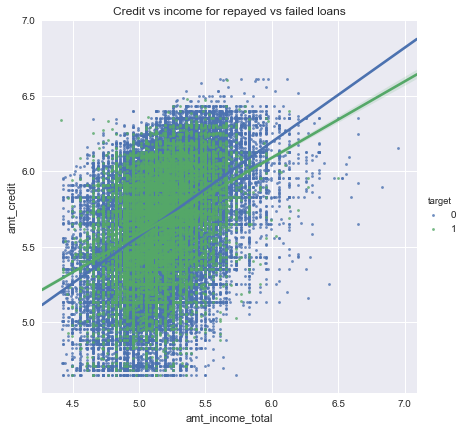

In [526]:
sns.lmplot(x='amt_income_total', y='amt_credit', hue='target', data=apps_df, size=6, scatter_kws={'s':8})
plt.title("Credit vs income for repayed vs failed loans")
plt.show()

Surprisingly, it seems that there's actually a lower correlation between income and loan amount for failed loans than for loans with no repayment problem.  This may be attributable to greater lender caution with higher loan amounts.

### Correlations & redundancies

Now let's take a look at our variable correlations and see if any are too redundant to keep as separate features.

In [ ]:
non_binary_cols = [colname for colname in apps_df.columns if not colname.startswith('flag')]
corr = apps_small_df[non_binary_cols].corr()

# throws super perplexing KeyError!!!
# persists even with non_binary_cols = [colname.replace('\n', '') for colname in apps_df.columns if not colname.startswith('flag')]

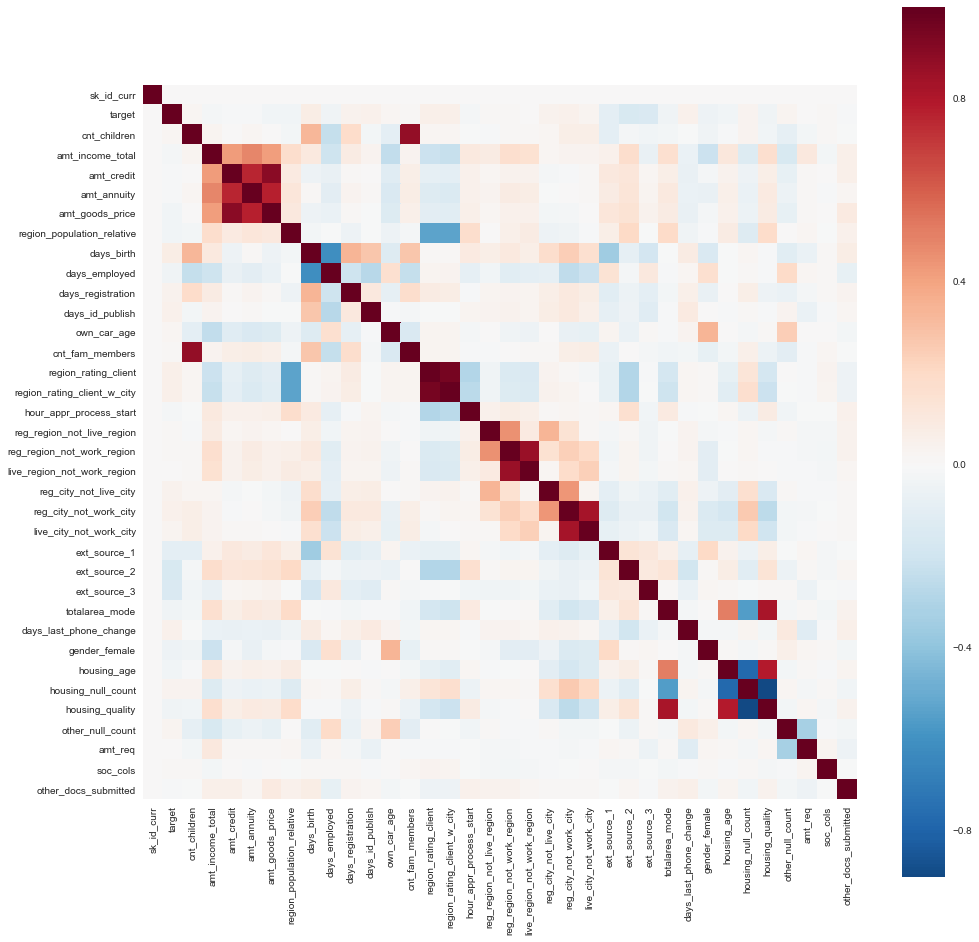

In [188]:
binary_cols = ['flag_own_car', 'flag_own_realty', 'flag_mobil', 'flag_emp_phone', 'flag_work_phone', 'flag_cont_mobile', 'flag_phone', 'flag_email', 'flag_document_3', 'flag_document_6', 'flag_document_8']
corr = apps_small_df.drop(binary_cols, axis=1).corr()
plt.figure(figsize=(16,16))
sns.heatmap(corr, square=True, center=0, cmap='RdBu_r');
plt.show()

Based on these correlations, we can remove a few features from our datasets:

In [170]:
redundant_cols = ['housing_null_count',
                  'amt_goods_price', 
                  'cnt_fam_members', 
                  'region_rating_client_w_city', 
                  'live_region_not_work_region', 
                  'live_city_not_work_city']
# note: housing age is borderline-redundante with housing quality and could potentially be dropped as well

apps_df.drop(redundant_cols, axis=1, inplace=True)
apps_small_df.drop(redundant_cols, axis=1, inplace=True)

In [2]:
# apps_df = pd.read_csv('apps_df.csv', index_col=0)
# apps_small_df = pd.read_csv('apps_small_df.csv', index_col=0)

### Encoding categorical variables

Some of our basic models won't be able to handle categorical variables directly.  We'll generate a basic encoded dataset to use in those cases.

In [172]:
# quantitates-only, with no binaries at all:
X_quant = apps_small_df.select_dtypes(exclude=['object', 'bool']).drop('target', axis=1)
y = apps_df['target']

In [173]:
# define two functions for custom numerical encoding:
def mean_encode(colname, target, dframe):
    '''returns column with each value replaced with the mean of target column for that value '''    
    value_means = {}
    for value in dframe[colname].unique():
        value_means[value] = round(dframe[dframe[colname]==value][target].mean()*100, 1)
    return dframe[colname].apply(lambda x: value_means[x])

def mean_seq_encode(colname, target, dframe):
    '''returns column with each value replaced by the integer index of the value in a list of values
    sorted by the mean of the target value for that column'''
    value_means = []
    for value in dframe[colname].unique():
        value_means.append( (value, dframe[dframe[colname]==value][target].mean()) )
    value_means = sorted(value_means, key=lambda x: x[1])
    # create dictionary of {value, index-in-list-sorted-by-mean}
    value_seq = {}
    i = 0
    for tup in value_means:
        value_seq[tup[0]] = i
        i+=1
    return dframe[colname].apply(lambda x: value_seq[x])

In [176]:
# occupation type and organization type have lots of unique values (19 and 59, respectively). 
# We'll numerically them, with the number for a label representing the mean target value for that label:
X_sm_encoded = apps_small_df.copy()
X_sm_encoded['occupation_type_seq'] = mean_seq_encode('occupation_type', 'target', X_sm_encoded)
X_sm_encoded['occupation_type'] = mean_encode('occupation_type', 'target', X_sm_encoded)
X_sm_encoded['organization_type_seq'] = mean_seq_encode('organization_type', 'target', X_sm_encoded)
X_sm_encoded['organization_type'] = mean_encode('organization_type', 'target', X_sm_encoded)

X_sm_encoded.drop('target', axis=1, inplace=True)

# we'll one-hot encode the rest of our categorical variables, which all have eight or fewer values
X_sm_encoded = pd.get_dummies(X_sm_encoded)
X_sm_encoded.head()

,sk_id_curr,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,region_population_relative,days_birth,days_employed,...,wallsmaterial_mode_Block,wallsmaterial_mode_Mixed,wallsmaterial_mode_Monolithic,wallsmaterial_mode_Others,wallsmaterial_mode_Panel,"wallsmaterial_mode_Stone, brick",wallsmaterial_mode_Unknown,wallsmaterial_mode_Wooden,emergencystate_mode_No,emergencystate_mode_Yes
0,100002,False,True,0,202500.0,406597.5,24700.5,0.018801,-9461,-637,...,0,0,0,0,0,1,0,0,1,0
1,100003,False,False,0,270000.0,1293502.5,35698.5,0.003541,-16765,-1188,...,1,0,0,0,0,0,0,0,1,0
12,100016,False,True,0,67500.0,80865.0,5881.5,0.031329,-13439,-2717,...,0,0,0,0,0,0,1,0,1,0
13,100017,True,False,1,225000.0,918468.0,28966.5,0.016612,-14086,-3028,...,0,0,0,0,1,0,0,0,1,0
14,100018,False,True,0,189000.0,773680.5,32778.0,0.010006,-14583,-203,...,0,0,0,0,1,0,0,0,1,0


# Model Performance Baselines

Before we move on to feature engineering and feature reduction, we should figure out which models seem to work well on our basic version of this dataset.  We'll take the performances of our top two models on this dataset as our benchmarks.  (Our performance metric, as dictated by the Kaggle contest, is AUROC).  Later, for our more heavily engineered versions of the datset, the performance of these models will be our criterion for determining which modifications (added features, reduced featuresets, etc.) are most helpful.

In particular, we'll try:
- linear regression (with Stochastic Gradient Descent)
- Naive Bayes
- Random Forest
- XGBoost
- LightGBM
- CatBoost
- SVC with kernel approximation (pure SVC will take a lot of processing time)

In [179]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
# http://scikit-learn.org/stable/modules/kernel_approximation.html

In [33]:
def testModel(model, X_set):
    start = time()
    scores = cross_validate(model, X_set, y, cv=3, 
                            scoring='roc_auc', return_train_score=True)
    print("Mean train AUROC:", np.mean(scores['train_score']))
    print("Mean test AUROC:", np.mean(scores['test_score']))
    print("Elapsed time:", round((time()-start)/60), 'minutes')

def testModels(model_tups, X_set):
    ''' model_tups = [ (model, name), (model, name) ]'''
    for tup in model_tups: 
        start = time()
        scores = cross_validate(tup[0], X_set, y, cv=3, 
                        scoring='roc_auc', return_train_score=True)
        print(tup[1] + ':')
        print("  Mean train AUROC:", round(np.mean(scores['train_score']), 4)
        print("  Mean test AUROC:", round(np.mean(scores['test_score']), 4)
        print("  Elapsed time:", round((time()-start)/60), 'minutes\n')

In [371]:
sgd = SGDClassifier(loss='hinge', penalty='l1', alpha=.0001, max_iter=25, random_state=11)
gnbc = GaussianNB()
rfc = RandomForestClassifier(n_estimators=100)
lgbmc = LGBMClassifier()
xgbc = XGBClassifier()
cbc = CatBoostClassifier(iterations=300, verbose=False)

model_tups = [
    (sgd, "SGD logistic regression"),
    (gnbc, "Naive Bayes"),
    (rfc, "Random Forest"),
    (xgbc, "XGBoost"),
    (lgbmc, "LightGBM"),
    (cbc, "CatBoost") 
]

testModels(model_tups, X_sm_encoded)

SGD logistic regression:
  Mean train AUROC: 0.5769022881935183
  Mean test AUROC: 0.5865706463745279
  Elapsed time: 0 minutes

Naive Bayes:
  Mean train AUROC: 0.6348737154026584
  Mean test AUROC: 0.6345716553279511
  Elapsed time: 0 minutes

Random Forest:
  Mean train AUROC: 1.0
  Mean test AUROC: 0.6877217902668434
  Elapsed time: 5 minutes

XGBoost:
  Mean train AUROC: 0.7585623647793106
  Mean test AUROC: 0.735536484967723
  Elapsed time: 3 minutes

LightGBM:
  Mean train AUROC: 0.7950088736501995
  Mean test AUROC: 0.7450554409436373
  Elapsed time: 1 minutes

CatBoost:
  Mean train AUROC: 0.7638477737151842
  Mean test AUROC: 0.7525831455016982
  Elapsed time: 6 minutes



This gives us a good idea of the scores for the most basic versions of these models.  However, while all of these models could be optimized further, this test is particularly unfair to LightGBM and CatBoost, because they can both handle categorical variables directly with the right parameters – right now we're just feeding them dummies like the other algorithms.  (It's also pretty unfair to Naive Bayes since it's treating all the variables as Gaussian when half are Bernoulli, but that's scoring so low that it's not worth worrying about for now.)

Let's try running those two again, but with the full categorical data instead of just the dummy versions.

In [ ]:
from sklearn.svm import SVC
svc = SVC()
testModel(svc, X_sm_encoded)
# NOTE: ran for 12 minutes; halted

In [378]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
# http://scikit-learn.org/stable/modules/kernel_approximation.html

rbf_sampler = RBFSampler(n_components=140)
X_rbf = rbf_sampler.fit_transform(X_sm_encoded)
sgd = SGDClassifier(alpha=.0001, random_state=11)
testModel(sgd, X_rbf)

/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/site-packages/s

Mean train AUROC: 0.5017993961485866
Mean test AUROC: 0.5021941509087999
Elapsed time: 0 minutes


#### Testing direct categorical handling

In [192]:
# LightGBM can process categorical cols IF they have integer values AND are explicitly declared in parameters
from sklearn.model_selection import train_test_split
X_num_encoded = apps_small_df.copy()
X_cat_indices = []
for colname in X_num_encoded:
    if X_num_encoded.dtypes[colname]=='object':
        X_cat_indices.append(list(X_num_encoded.columns).index(colname))
        X_num_encoded[colname] = mean_seq_encode(colname, 'target', X_num_encoded)
        
y = X_num_encoded['target']
X_num_encoded.drop('target', axis=1, inplace=True) # shifts the indices above, hence the ind-1 offset in next line
X_cat_indices = [ind-1 for ind in X_cat_indices]
X_num_train, X_num_test, y_train, y_test = train_test_split(X_num_encoded, y, test_size = 1/3)

# create LightGBM-specific datasets with the categorical cols explicitly declared
lgbm_train = lgb.Dataset(X_num_train, label=y_train, categorical_feature=X_cat_indices)
lgbm_test = lgb.Dataset(X_num_test, label=y_test, categorical_feature=X_cat_indices)

In [193]:
from sklearn.metrics import roc_auc_score

# then test LightGBM on this dataset
start = time()
lgbmc = lgb.train({},lgbm_train)
y_train_pred = lgbmc.predict(X_num_train)
y_test_pred = lgbmc.predict(X_num_test)
train_score = round(roc_auc_score(y_train, y_train_pred), 4)
test_score = round(roc_auc_score(y_test, y_test_pred), 4)
etime = round((time()-start)/60, 1)
print("AUROC train score:", train_score)
print("AUROC test score:", test_score)
print("Elapsed time:", etime, "minutes")

/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


AUROC train score: 0.8235
AUROC test score: 0.7373
Elapsed time: 0.1 minutes


In [241]:
import catboost as cb

start = time()
cbc = cb.CatBoostClassifier(eval_metric='AUC', iterations=300, verbose=False)
cbc.fit(X_num_train, y_train, cat_features=X_cat_indices)
y_train_pred = cbc.predict(X_num_train)
y_test_pred = cbc.predict(X_num_test)
train_score = round(roc_auc_score(y_train, y_train_pred), 4)
test_score = round(roc_auc_score(y_test, y_test_pred), 4)
etime = round((time()-start)/60, 1)
print("AUROC train score:", train_score)
print("AUROC test score:", test_score)
print("Elapsed time:", etime, "minutes")

AUROC train score: 0.5
AUROC test score: 0.5
Elapsed time: 2.1 minutes


In [ ]:
# Trying again, but with non-num-encoded categorical data
X = apps_small_df.drop('target', axis=1)
y = apps_small_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3)

start = time()
cbc = cb.CatBoostClassifier(eval_metric='AUC', iterations=300, verbose=False)
cbc.fit(X_num_train, y_train, cat_features=X_cat_indices)
y_train_pred = cbc.predict(X_train)
y_test_pred = cbc.predict(X_test)
train_score = round(roc_auc_score(y_train, y_train_pred), 4)
test_score = round(roc_auc_score(y_test, y_test_pred), 4)
etime = round((time()-start)/60, 1)
print("AUROC train score:", train_score)
print("AUROC test score:", test_score)
print("Elapsed time:", etime, "minutes")

So we can see that LightGBM sees a slight *reduction* in test score here (0.745-->0.737) when passed explicit categorical tags - although the train score increases significantly, so this may be a fixable overfitting issue.

For reasons that are unclear, CatBoost totally falls apart when passed the categorical indices.  The syntax is identical to the syntax of numerous working examples online.

For now, given the lack of drastic performance improvement for either model, we can feel free to test our datasets on LightGBM without categorical flags (which would require generating a new list of categorical flags every time).  Once we've decided on our best dataset and are doing our final model optimizations, we can try adding these back in.

# Feature engineering

First let's take a quick look at our feature importances:

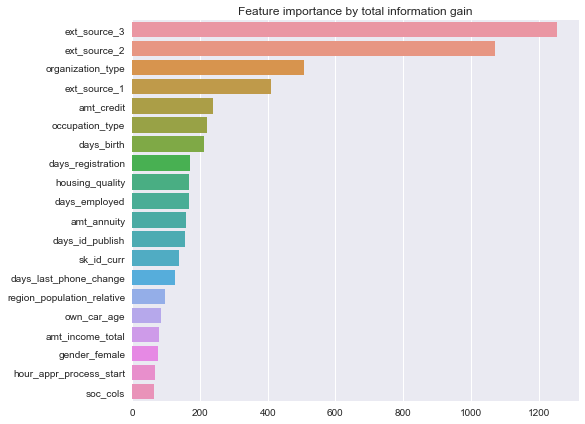

In [232]:
def plot_importances(X_train, model):
    labeled_fi = sorted( list(zip(X_train.columns, model.feature_importance(importance_type='gain'))), key=lambda x: -x[1])
    plt.figure(figsize=(8,7))
    x_imp = [tup[0] for tup in labeled_fi[:20]]
    y_labels = [tup[1] for tup in labeled_fi[:20]]
    sns.barplot(y_labels, x_imp)
    plt.title("Feature importance by total information gain")
    plt.show()
    
importances = [round(i) for i in lgbmc.feature_importance(importance_type='gain')]
plot_importances(X_num_train, lgbmc)

This makes sense: the previous evaluations from other sources (ext_source_3 etc.) are highly predictive; organization type and occupation type are important; the amount of the loan and the age of the applicant are important.  No big surprises here.  

Now let's try engineering some features based on understanding of the data.

In [239]:
def add_eng_cols(df):
    df['payment_rate'] = df['amt_annuity']/df['amt_credit']
    df['relative_annuity'] = df['amt_annuity']/(df['amt_income_total'] + 1)
    return df

# consider adding either income or net worth relative to mean for profession

In [240]:
apps_df = add_eng_cols(apps_df)
apps_small_df = add_eng_cols(apps_small_df)

In [235]:
df = apps_small_df[:10000].copy()

# Table merges
- load all ancillary tables
- choose and implement merging method for cases with multiple rows per person
- create two versions of every table: (1) only >90%-null columns dropped; (2) manually de-nulled
- create two merged Total Dataset: the with nulls (for GLRM imputation, with raw apps) and without nulls (for PCA/PLS, with numerical apps)

NOTE: may need to add a bool column for isMissing for cases where the null-ness is likely significant

The first thing we will need to do with these datasets is group them by current id so that we can perform joins etc.

## Previous Applications & associated

#### Includes: previous_application, POS_CASH_balance, instalments_balance, credit_card_balance

In [44]:
# LOAD AND CLEAN:
previous_df = pd.read_csv("previous_application.csv")
previous_df.columns = [str.lower(column) for column in previous_df.columns]

# fill accompanying person and downpayment appropriately
previous_df['name_type_suite'].fillna(value='Unaccompanied', inplace=True)
previous_df['amt_down_payment'].fillna(value=0, inplace=True)

# convert Y/N to boolean
previous_df['flag_last_appl_per_contract'] = previous_df['flag_last_appl_per_contract']=='Y'

# drop three columns that are overwhelmingly null
previous_df.drop(['rate_down_payment',
                  'rate_interest_primary',
                  'rate_interest_privileged',
                  'name_cash_loan_purpose'], 
                 axis=1, inplace=True)

The previous applications datasheet contains 1.7 million previous loan applications by individuals who have current applications in the main spreadsheet.  Some quick stats:
- about 200,000 of the 300,000 applicants in our test sheet have past loans on record here
- the typical applicant in the previous applications sheet has four previous applications (median)

Let's take a quick look at two key distributions.  First, the number of applications per applicant:

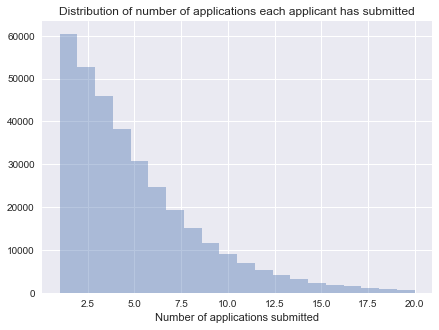

In [248]:
plt.figure(figsize=(7,5))
sns.distplot([val for val in previous_df.sk_id_curr.value_counts() if val <= 20], kde=False, bins=20)
plt.title('Distribution of number of applications each applicant has submitted')
plt.xlabel('Number of applications submitted')
plt.show()

We can see that this is a pretty basic Poisson distribution - and that a large majority of current applicants who applied previously applied more than once previously.

And let's look at the distribution of how long ago these applications were submitted:

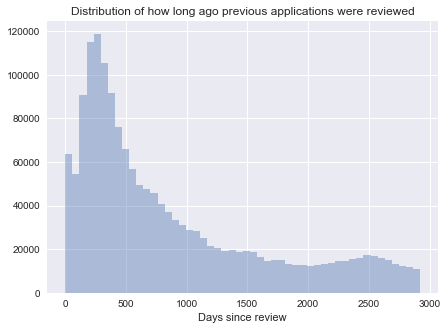

In [251]:
plt.figure(figsize=(7,5))
sns.distplot(previous_df.days_decision*-1, kde=False)
plt.title('Distribution of how long ago previous applications were reviewed')
plt.xlabel('Days since review')
plt.show()

This shows us that the typical previous application was about a year old, and that the records go back about nine years (hence the hard cutoff at the far right).

The main challenge of the "previous applications" table is that it has multiple entries for many loan applicants.  We'll deal with this in two stages.  First, we'll create a table *prev_df* of just the most recent ("previous") application by each applicant, since this will be the most important information.  Then, we'll create a second table *past_df* summarizing all other past applications by grouping by applicant and using three different ways of combining the applicant's values from these applications:
- for numerical columns, we'll just take the mean
- for most categorical columns, we'll take the most common entry
- for a few particularly important numerical columns, we'll one-hot encode them and then sum them

First, however, we'll need to process and incorporate our ancillary-ancillary tables that contain supplementary information about previous loans.

### Supplementary tables for previous applications

<b>The POS_CASH_balance table</b> will useful for getting average days late on loans.  Beyond that, the montly timestamps for lateness aren't going to be much use unless we want to assemble some sort of time series.  (We could include the timestamp for the first late payment, but since 95% of loans didn't have any late payments at all, these timestamps would be overwhelmingly null.)

In [25]:
#load 
pcb_df = pd.read_csv("POS_CASH_balance.csv")
pcb_df.columns = [str.lower(column) for column in pcb_df.columns]

# rename name_contract_status to avoid confusion with previous_df column of same name:
# (not doing this creates an evil combinatorial-column-proliferation problem when groupby-ing the combined table)
pcb_df.rename(columns={'name_contract_status':'pcb_name_contract_status'}, inplace=True)

# compress pcb_df to one row per loan, compiling averages for days late
pcb_df = pcb_df[['sk_id_prev', 'sk_dpd', 'sk_dpd_def', 'pcb_name_contract_status']]
pcb_df = pcb_df[~pcb_df.pcb_name_contract_status.isin(['Canceled', 'XNA'])] # these 17 rows aren't worth 2 new dummy cols
pcb_df = pd.get_dummies(pcb_df, 'pcb_name_contract_status')
pcb_df = pcb_df.groupby('sk_id_prev', as_index=False).agg('mean')
# some renaming for clarity:
pcb_df.rename(columns={
    'sk_dpd':'av_dpd_minor',
    'sk_dpd_def':'av_dpd_major' 
    }, inplace=True)

<b>The install payments table</b> will yield some useful information on past payments such as average days late, percentage left unpaid, etc.

In [5]:
# load
install_payments_df = pd.read_csv('installments_payments.csv')
install_payments_df.columns = [str.lower(column) for column in install_payments_df.columns]

# create combination columns
install_payments_df['pct_unpaid'] = (
    (install_payments_df.amt_instalment - install_payments_df.amt_payment) / install_payments_df.amt_instalment )
install_payments_df['days_late'] = install_payments_df.days_entry_payment - install_payments_df.days_instalment

# drop columns we don't have use for
install_payments_df.drop(['num_instalment_version', 
                          'amt_payment',
                          'days_entry_payment',
                          'sk_id_curr'], axis=1, inplace=True)

# group by loan
agg_funcs = {'num_instalment_number':'count',
            'days_instalment':['min', 'max'],
            'pct_unpaid':['mean', 'max'],
            'days_late':['mean', 'max']}
install_payments_df = install_payments_df.groupby('sk_id_prev', as_index=False).agg(agg_funcs)
# flatten multiindex
install_payments_df.columns = ['_'.join(col) for col in install_payments_df.columns]
install_payments_df.rename(columns={'sk_id_prev_':'sk_id_prev'}, inplace=True)

In [68]:
install_payments_df.shape

(997752, 8)

<b>The credit card balance table</b> includes a sk_id_prev flag like the other supplementary tables to the previous applications, but it's not totally clear how this relates to to teh sk_id_prev element of the other tables here.  The description unhelpfully states that it contains "every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample" without giving any further specification of *how* it's related.

The best as I can figure, this is simply a list of credit card balances and payments during the periods of the different loans.  Given that we have the time distinction of being one loan vs another, we'll get more overall information if we group this with the other past application data.  However, if these features come up empty for importance later, it may be worth trying this as a totally separate table grouped by sk_id_curr rather than sk_id_prev.

<b>The other big problem with this dataset is that it only contains entries for about 100K previous loans.</b>  That's only around 7% of them.  Because of this, we'll keep this table separate for now.  GLRM can typically handle this amount of nulls given a reasonably robust remainder of the table, but we'll experiment with that later (either merging it directly to the main dataset, or parsing it through the past/prev splitting below).

In [65]:
# load
cc_bal_df = pd.read_csv('credit_card_balance.csv')
cc_bal_df.columns = [str.lower(column) for column in cc_bal_df.columns]

# generate pcdt_unpaid column
cc_bal_df['pct_unpaid'] = (cc_bal_df.amt_balance - cc_bal_df.amt_payment_current) / (cc_bal_df.amt_balance + 1)

# drop sk_id_curr (we'll groupby and later join with sk_id_prev)
cc_bal_df.drop('sk_id_curr', axis=1, inplace=True)

# these 22 rows out of 3 mil aren't worth 2 new dummy cols:
cc_bal_df = cc_bal_df[~cc_bal_df.name_contract_status.isin(['Refused', 'Approved'])]
cc_bal_df = pd.get_dummies(cc_bal_df, 'name_contract_status')

# because this dataset is pretty opaque, we're just going to take the mean and var of every column for each user
cc_bal_df = cc_bal_df.groupby('sk_id_prev', as_index=False).agg(['mean','var'])
cc_bal_df.columns = ['_'.join(col) for col in cc_bal_df.columns]
# but we don't need variance for the binary dummy columns:
cc_bal_df.drop(['name_contract_status_Active_var',
                'name_contract_status_Completed_var',
                'name_contract_status_Demand_var',
                'name_contract_status_Sent proposal_var',
                'name_contract_status_Signed_var'], axis=1, inplace=True)
cc_bal_df.reset_index(inplace=True) # because for some reason pandas ignores the as_index=False option above

In [22]:
cc_bal_df.shape

(104307, 48)

Now we'll join our other two subsidiary tables (omitting cc_bal_df because of its null-sparsity) onto our main table.

In [46]:
all_previous_df = previous_df.merge(
    pcb_df, on='sk_id_prev', how='left').merge(
    install_payments_df, on='sk_id_prev', how='left')

In [27]:
all_previous_df.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_contract_status_Demand,name_contract_status_Returned to the store,name_contract_status_Signed,num_instalment_number_count,days_instalment_min,days_instalment_max,pct_unpaid_mean,pct_unpaid_max,days_late_mean,days_late_max
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,0.0,0.0,0.0,1.0,-42.0,-42.0,0.0,0.0,0.000000,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,0.0,607500.0,THURSDAY,11,...,0.0,0.0,0.0,5.0,-134.0,-14.0,0.0,0.0,-9.200000,-7.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,0.0,112500.0,TUESDAY,11,...,0.0,0.0,0.0,9.0,-271.0,-31.0,0.0,0.0,-8.222222,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,0.0,450000.0,MONDAY,7,...,0.0,0.0,0.0,11.0,-482.0,-182.0,0.0,0.0,-7.090909,0.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,0.0,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, we'll execute our strategy for splitting the data into one table of just the most recent loan, and one table of all the other past loans.

In [50]:
# define utility functions for splitting prev (most recent) vs past and grouping past applications by applicant
def split_past_prev(df, time_col, past_id):
    '''
    time_col = column that contains days since application
    past_id = column that contains id of the loan represented by the row
    '''
    start = time()
    df = df.sort_values(by=['sk_id_curr', time_col]) # each group sorted by days_decision so most recent is last
    prev_df = df.groupby('sk_id_curr').nth(-1) # selects last entry from each group
    past_df = df[~df[past_id].isin(prev_df[past_id])] # selects all entries not in previous_df
    print("Elapsed time (minutes):", round((time()-start)/60, 1))
    return (past_df, prev_df)

def categorical_mode(series):
    if series.count() == 0:
        return float('NaN')
    else:
        return series.mode()[0]

def group_apps(df, count_col, cats_to_encode=[]):
    start = time()
    
    # eliminate spaces from column names:
    df.columns = [col.replace(' ', '_') for col in df.columns]
    
    cat_cols = []
    for col in df.columns:
        if df.dtypes[col] == 'object' and col not in cats_to_encode:
            cat_cols.append(col)
    num_cols = [col for col in df.columns if col not in (cat_cols + cats_to_encode)]
    df = pd.get_dummies(df, columns=cats_to_encode)
    # eliminate spaces from column names:
    df.columns = [col.replace(' ', '_') for col in df.columns]
    dummy_cols = [col for col in df.columns if col not in (num_cols + cat_cols + cats_to_encode)]
    
    agg_funcs = {}
    for col in dummy_cols:
        agg_funcs[col] = 'sum'
    for col in num_cols:
        agg_funcs[col] = 'mean'
    for col in cat_cols:
        agg_funcs[col] = categorical_mode  # custom function defined above
    agg_funcs[count_col] = 'count'  # we'll rename this prev_app_count below
    
    print("Performing groupby...")
    grouped_df = df.groupby('sk_id_curr').agg(agg_funcs)  # NOTE: takes a while
    grouped_df.rename(columns={count_col:'prev_app_count'}, inplace=True)
    
    print("Elapsed time (minutes):", round((time()-start)/60, 1))
    return grouped_df

In [58]:
past_df, prev_df = split_past_prev(all_previous_df, 
                                   time_col='days_decision', 
                                   past_id='sk_id_prev')
past_df = group_apps(past_df, 
                     count_col='sk_id_prev', 
                     cats_to_encode=['name_contract_type','name_contract_status','name_payment_type'])

Elapsed time (minutes): 0.1
Performing groupby...
Elapsed time (minutes): 20.1


In [70]:
prev_df.shape

(338857, 48)

In [69]:
past_df.shape

(278399, 58)

In [73]:
# quick garbage collection cleanup to keep our kernel manageable
del previous_df, all_previous_df, pcb_df, install_payments_df
gc.collect()

2681

## Bureau & bureau balance

The Bureau dataframe is like the previous applications table, except that it contains previous applications with other financial institutions, and the information about those applications recorded in the columns is a bit different.  We'll treat it in exactly the same way we treated the previous applications table: split it into one most-recent-app table, and one aggregated all-other-past-apps table.

First, however, we'll need to join the data from the <b>bureau balance</b> table.  The bureau balance table contains as distinct rows the monthly loan status for each month for each previous loan with other institutions.  This only contains the loan IDs, and not the current applicant IDs.  We'll consolidate the rows such that each row represents just one previous loan.  Then we'll join this table to the main Bureau table, since they're effectively just a couple more stats for each loan.  Specifically, these stats represent how many months each loan spent with which loan status.

In [78]:
# load
bureau_balance_df = pd.read_csv('bureau_balance.csv')
bureau_balance_df.columns = [str.lower(column) for column in bureau_balance_df.columns]
# drop not-so-useful column
bureau_balance_df.drop('months_balance', axis=1, inplace=True)
# generate dummies for the main categorical var for groupby-ing down to one entry per loan
bureau_balance_df = pd.get_dummies(bureau_balance_df, 'status')
# groupby and generate a total months column:
bureau_balance_df = bureau_balance_df.groupby('sk_id_bureau', as_index=False).agg('sum')
bureau_balance_df['total_months'] = bureau_balance_df[bureau_balance_df.columns[1:]].sum(axis=1)
bureau_balance_df.head()

,sk_id_bureau,status_0,status_1,status_2,status_3,status_4,status_5,status_C,status_X,total_months
0,5001709,0,0,0,0,0,0,86,11,97
1,5001710,5,0,0,0,0,0,48,30,83
2,5001711,3,0,0,0,0,0,0,1,4
3,5001712,10,0,0,0,0,0,9,0,19
4,5001713,0,0,0,0,0,0,0,22,22


In [75]:
bureau_balance_df = pd.read_csv('bureau_balance.csv')
bureau_balance_df.columns = [str.lower(column) for column in bureau_balance_df.columns]
bureau_df = pd.read_csv("bureau.csv")
bureau_df.columns = [str.lower(column) for column in bureau_df.columns]
# there are only two columns that are over half null, and they're both around 70% and important enough to keep

In [79]:
# load
bureau_df = pd.read_csv("bureau.csv")
bureau_df.columns = [str.lower(column) for column in bureau_df.columns]
# no null-dropping: only two columns are over half null, and they're both around 70% and important enough to keep
bureau_df.head()

,sk_id_curr,sk_id_bureau,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


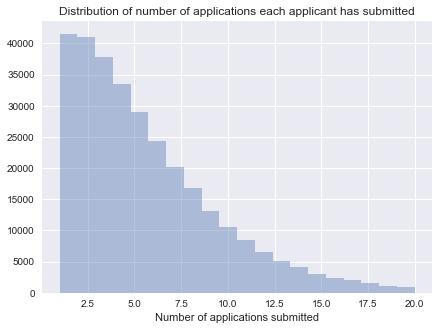

In [397]:
plt.figure(figsize=(7,5))
sns.distplot([val for val in bureau_df.sk_id_curr.value_counts() if val <= 20], kde=False, bins=20)
plt.title('Distribution of number of applications each applicant has submitted')
plt.xlabel('Number of applications submitted')
plt.show()

To confirm: the distribution of the number of previous applications an applicant has submitted is comparable to that distribution for the previous_applications table (albeit the total number of applicants represented is about 30% less, so about half of our total applicants in the main apps_df table).

In [80]:
bureau_df = pd.merge(bureau_df, bureau_balance_df, on='sk_id_bureau', how='left')

In [81]:
past_bureau_df, prev_bureau_df = split_past_prev(bureau_df, 'days_credit', 'sk_id_bureau')
past_bureau_df = group_apps(past_bureau_df, 'sk_id_bureau', cats_to_encode=['credit_active'])
# bonus: add credit_type to special columns (has six main types, but another eight or so with few values)

Elapsed time (minutes): 0.1
Performing groupby...
Elapsed time (minutes): 4.2


In [84]:
prev_bureau_df.to_csv('prev_bureau_df.csv')
past_bureau_df.to_csv('past_bureau_df.csv')

### Review of data
To review, our operative data tables now consist of:
- <b>apps_df:</b> our main apps data, complete with
- <b>apps_small_df:</b> a condensed and null-less version of the main apps table
- <b>prev_df:</b> data from each applicant's previous application, if the applicant has any on record
- <b>past_df:</b> data from each applicant's other past applications, if the applicant has any on record
- <b>prev_bureau_df:</b> data from each applicant's previous application with other agencies, if the applicant has any on record
- <b>past_bureau_df:</b> data from each applicant's other past applications with other agencies, if the applicant has any on record
- <b>cc_bal_df:</b> past credit card data for a small subset (<5%) of applicants


## TOTAL DATA RELOAD:

In [85]:
apps_df = pd.read_csv('apps_df.csv')
apps_small_df = pd.read_csv('apps_small_df.csv')

In [88]:
apps_df.shape

(307511, 78)

In [89]:
apps_small_df.shape

(158940, 56)

In [ ]:
apps_df = pd.read_csv('apps_df.csv')
apps_small_df = pd.read_csv('apps_small_df.csv')
prev_df = pd.read_csv('prev_df.csv')
past_df = pd.read_csv('past_df.csv')
prev_bureau_df = pd.read_csv('prev_bureau_df.csv')
past_bureau_df = pd.read_csv('past_bureau_df.csv')
cc_bal_df = pd.read_csv('cc_bal_df.csv')

# Feature reduction & imputing methods

Now that we have our data compiled, we'll work to reduce them down to a manageably-sized, null-less datase to run our predictive algorithms on.  We'll try a couple methods here:
- <b>GLRM total:</b> running GLRM on a merged version of all the above data
- <b>GLRM piecemeal:</b> running GLRM on each ancillary dataset above, and merging the reduced tables to the main dataset
- <b>PCA:</b> running PCA to reduce a mean-imputed, one-hot-encoded version of the total datset
- <b>PLS:</b> running PLS to reduce a mean-imputed, one-hot-encoded version of the total dataset

## GLRM total

In [ ]:
start = time()
full_dataset = apps_df.merge(
    prev_df, on="sk_id_curr", how="left").merge(
    past_df, on="sk_id_curr", how="left").merge(
    prev_bureau_df, on="sk_id_curr", how="left").merge(
    past_bureau_df, on="sk_id_curr", how="left").merge(
)
print(round(((time()-start)/60),2), "seconds")

## GLRM piecemeal

# Scratch

In [5]:
df2 = pd.DataFrame({ 'A' : 1.,
                         'B' : pd.Timestamp('20130102'),
                         'C' : pd.Series(1,index=list(range(4)),dtype='float32'),
                         'D' : np.array([3] * 4,dtype='int32'),
                         'E' : pd.Categorical(["test","train","test","train"]),
                         'F' : 'foo' })

In [6]:
df2.head()

,A,B,C,D,E,F
0,1.0,2013-01-02,1.0,3,test,foo
1,1.0,2013-01-02,1.0,3,train,foo
2,1.0,2013-01-02,1.0,3,test,foo
3,1.0,2013-01-02,1.0,3,train,foo


In [17]:
df2.groupby('A').agg(lambda x: sp.stats.mode(x)[0][0])

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:245: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


,B,C,D,E,F
A,,,,,
1.0,2013-01-02,1.0,3,test,foo


In [99]:
withheld = [num for num in previous_df.sk_id_curr.unique() if num not in raw_apps_df.sk_id_curr]
print(len(withheld))

141594


In [100]:
repeats = [num for num in previous_df.sk_id_curr.unique() if num in raw_apps_df.sk_id_curr]
print(len(repeats))

197263


In [24]:
previous_df.head()

,sk_id_prev,sk_id_curr,name_contract_type,amt_annuity,amt_application,amt_credit,amt_down_payment,amt_goods_price,weekday_appr_process_start,hour_appr_process_start,...,name_seller_industry,cnt_payment,name_yield_group,product_combination,days_first_drawing,days_first_due,days_last_due_1st_version,days_last_due,days_termination,nflag_insured_on_approval
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
previous_df.name_contract_status.value_counts()

Approved        1036781
Canceled         316319
Refused          290678
Unused offer      26436
Name: name_contract_status, dtype: int64

In [ ]:
previous_df.name_contract_status.value_counts()

In [86]:
previous_df.shape

(1670214, 37)

In [85]:
previous_df.isnull().sum()

SK_ID_PREV                           0
SK_ID_CURR                           0
NAME_CONTRACT_TYPE                   0
AMT_ANNUITY                     372235
AMT_APPLICATION                      0
AMT_CREDIT                           1
AMT_DOWN_PAYMENT                895844
AMT_GOODS_PRICE                 385515
WEEKDAY_APPR_PROCESS_START           0
HOUR_APPR_PROCESS_START              0
FLAG_LAST_APPL_PER_CONTRACT          0
NFLAG_LAST_APPL_IN_DAY               0
RATE_DOWN_PAYMENT               895844
RATE_INTEREST_PRIMARY          1664263
RATE_INTEREST_PRIVILEGED       1664263
NAME_CASH_LOAN_PURPOSE               0
NAME_CONTRACT_STATUS                 0
DAYS_DECISION                        0
NAME_PAYMENT_TYPE                    0
CODE_REJECT_REASON                   0
NAME_TYPE_SUITE                 820405
NAME_CLIENT_TYPE                     0
NAME_GOODS_CATEGORY                  0
NAME_PORTFOLIO                       0
NAME_PRODUCT_TYPE                    0
CHANNEL_TYPE             

# Feature reduction and combination

I'm going to use three methods here:

Staged GLRM:
- For each ancillary table (with nulls), GLRM down to a few features.  Include these in main table.  This will add maybe 30-40 features.
- Consider GLRMing the main dataset down to 20 features.
- Run on this dataset

Brute Force GLRM:
- GLRM the whole damn Total Dataset, nulls and everything, down to 50 features

PCA (mostly just a comparison point).  Run with:
- Manually null-less Total Dataset.
- GLRM-imputed Total Dataset.  (Sort of cheating - may as well just use GLRM at that point? - but would give me the basic comparison point I need.)
- PCA- / PLS-imputed nulls?  (Too much work to figure out, UNLESS sklearn can do it.)

PLS (same methods as PCA)


### Feature-importance-based

### GLRM

### GLRM + boosting
- GLRM on individual tables, then boost into main table

### One-hot + PCA

### One-hot + PLS

### NNMF

### binary encoding?

In [270]:
from category_encoders import binary

# http://contrib.scikit-learn.org/categorical-encoding/_modules/category_encoders/binary.html

### Testing
To recap, here is a current list of our datasets:
- <b>Raw data (raw_apps_df): </b> Our original dataset with only the most basic cleaning fixes
- <b>Manually-cleaned (apps_df): </b> Our basic manually-cleaned dataset
- <b>Manually-cleaned small (apps_small_df): </b> Our basic manually-cleaned dataset
- <b>GLRM-basic: </b> Our basic manually-cleaned dataset
- <b>apps_df: </b> Our basic manually-cleaned dataset

Let's take these datasets for a spin with our leading models and see which produce the best results.

In [ ]:
FIRST RUN GLRM TO GET GLRM DATASET. THEN try running OOB models (SGD, forest, xgboost, svm?) 
on the GLRM and non-reduced datasets.
***NOTE: XGboost can handle missing values; can use full dataset
    cross_val_predict

NOTES FROM OTHER NOTEBOOKS:
    - select categoricals more efficiently by using select_dtypes('object')
    - don't dummy encode binary columns; they don't need it
    - deal with the four XNA CODE_GENDER values?
    - 
    




Nice kernel with clear code! What makes new version of kernel get LB over 0.79?

Reply
Basically the Payment Rate feature. I dont know why, but it seems to be a magic feature kkk

df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

Reply
it isn't magic actually. I think the main feature is [CREDIT / ANNUITY]. The annuity is the amount need to be paid per Month and the credit is the total amount, by dividing you get the expected 'credit term', which is a quite useful information. Longer credit term could mean more risk to carry for the bank.

## Experimental

In [18]:
apps.head()

,sk_id_curr,target,name_contract_type,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,amt_credit,amt_annuity,...,flag_document_18,flag_document_19,flag_document_20,flag_document_21,amt_req_credit_bureau_hour,amt_req_credit_bureau_day,amt_req_credit_bureau_week,amt_req_credit_bureau_mon,amt_req_credit_bureau_qrt,amt_req_credit_bureau_year
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

## Sources
https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
- a nice intro to the data cleaning, dummy cols, etc
https://www.kaggle.com/jsaguiar/updated-0-792-lb-lightgbm-with-simple-features/code
 - no null filling; LightGBM handles nulls fine
 - some useful feature engineering at the start
 - useful Payment Rate feature: df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
 https://www.kaggle.com/codename007/home-credit-complete-eda-feature-importance
 - great exploration of all data features
 
 Check out https://www.kaggle.com/kailex/tidy-xgb-all-tables-0-791/code for xgboost

## Benchmarks
- my basic RF with downsized manually-filled dataset is 0.67, basic GB is 0.70
- Gentle Introduction's basic RF with fully-binarized dataset is 0.68, basic LightGBM is 0.75
- Aguiar's full-dataset optimized LightGBM is 0.79
- SUCCESS TIERS:
    - 0.75 is common (OOB LightGBM can get this)
    - 0.78 is high competence
    - 0.79 is the top kernel
- MY GOAL:
    - clear 0.8; place in top 100

## Outtakes


In [ ]:
pcb_df = pd.read_csv("POS_CASH_balance.csv")
pcb_df.columns = [str.lower(column) for column in pcb_df.columns]

# compile timestamp for when client first paid a small amount late
pcb_lateish_df = pcb_df[pcb_df['sk_dpd']>0][['sk_id_prev',
                                            'cnt_instalment', 
                                            'cnt_instalment_future',
                                            'name_contract_status',
                                            'sk_dpd']]
pcb_lateish_df = pcb_lateish_df.sort_values(by=['sk_id_prev', 'sk_dpd'])
pcb_lateish_df = pcb_lateish_df.groupby('sk_id_prev', as_index=False).nth(1)
pcb_lateish_df.rename(columns={
    'cnt_instalment':'first_month_lateish',
    'cnt_instalment_future':'remaining_months_lateish',
    'name_contract_status':'status_when_first_lateish'
    }, inplace=True)
pcb_lateish_df.drop('sk_dpd', axis=1, inplace=True)

# compile timestamp for when client first paid a large amount late
pcb_late_df = pcb_df[pcb_df['sk_dpd_def']>0][['sk_id_prev', 
                                            'cnt_instalment', 
                                            'cnt_instalment_future',
                                            'name_contract_status',
                                            'sk_dpd_def']]
pcb_late_df = pcb_late_df.sort_values(by=['sk_id_prev', 'sk_dpd_def'])
pcb_late_df = pcb_late_df.groupby('sk_id_prev', as_index=False).nth(1)
pcb_late_df.rename(columns={
    'cnt_instalment':'first_month_late',
    'cnt_instalment_future':'remaining_months_late',
    'name_contract_status':'status_when_first_late'
    }, inplace=True)
pcb_late_df.drop('sk_dpd_def', axis=1, inplace=True)

# compress pcb_df to one row per loan, compiling averages for days late
pcb_df = pcb_df[['sk_id_prev', 'sk_dpd', 'sk_dpd_def']]
pcb_df.groupby('sk_id_prev', as_index=False).agg('mean')
pcb_df.rename(columns={
    'sk_dpd':'av_dpd_minor',
    'sk_dpd_def':'av_dpd_major',
    }, inplace=True)

# merge timestamps back on
pcb_df = pd.merge(pcb_df, pcb_lateish_df, on='sk_id_prev', how='left')
pcb_df = pd.merge(pcb_df, pcb_late_df, on='sk_id_prev', how='left')

